# Step X: Exploratory Data Analysis

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

from skimage import io
import seaborn as sns
import geopandas as gpd
import contextily as cx

%matplotlib inline

## Overview of Dataset

First I look at the structure of the dataset. The images are seperated into four folders (training, validation, and two test sets) each with subfolders for damage and no damage classes.

The training set contains 5,000 damage images and 5,000 no damage images. The validation and test set 1 each contain 1,000 images of each class. Test set 2 contains 2,000 no damage images and 8,000 damage images, rerpesenting a situation where there is a class imbalance.

The images are 128x128 pixels. The filenames include latitude and longitude coordinates which can be used to plot the locations of the structures in relation to each other (see below).

In [184]:
#set main directory
DIR = '/Users/allankapoor/Documents/Springboard/structure_damage/data'

#list folders
os.listdir(DIR)

['.DS_Store', 'test', 'validation_another', 'train_another', 'test_another']

In [267]:
# number of images per class in training set
print('-------TRAIN-------')
print(f"No Damage: {len(os.listdir(os.path.join(DIR, 'train_another', 'no_damage')))}")
print(f"Damage: {len(os.listdir(os.path.join(DIR, 'train_another', 'damage')))}")

print('-----VALIDATION-----')
# number of images per class in validation set
print(f"No Damage: {len(os.listdir(os.path.join(DIR, 'validation_another', 'no_damage')))}")
print(f"Damage: {len(os.listdir(os.path.join(DIR, 'validation_another', 'damage')))}")

print('--------TEST--------')
# number of images per class in test set
print(f"No Damage: {len(os.listdir(os.path.join(DIR, 'test', 'no_damage')))}")
print(f"Damage: {len(os.listdir(os.path.join(DIR, 'test', 'damage')))}")

print('-------TEST 2-------')
# number of images per class in test set
print(f"No Damage: {len(os.listdir(os.path.join(DIR, 'test_another', 'no_damage')))}")
print(f"Damage: {len(os.listdir(os.path.join(DIR, 'test_another', 'damage')))}")

-------TRAIN-------
No Damage: 5000
Damage: 5000
-----VALIDATION-----
No Damage: 1000
Damage: 1000
--------TEST--------
No Damage: 1000
Damage: 1000
-------TEST 2-------
No Damage: 1000
Damage: 8000


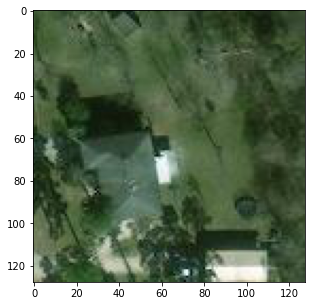

In [183]:
#load a sample image
tile_path = os.path.join(DIR, 'train_another', 'no_damage' , '-95.086_29.827665000000003.jpeg')
tile = io.imread(tile_path)

#plot image
plt.figure(figsize=(5,5))
plt.imshow(tile);

In [16]:
#image array shape
tile.shape

(128, 128, 3)

In [12]:
image_size = (128, 128)
batch_size = 32

train_dir = os.path.join(DIR, 'train_another')
val_dir = os.path.join(DIR, 'validation_another')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [268]:
#checking for corrupted images
num_skipped = 0
for folder_name in ("damage", "no_damage"):
    folder_path = os.path.join(DIR,'train_another', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            
            print(fpath)
            # Delete corrupted image
            #os.remove(fpath)

print(f"There are {num_skipped} corrupted images")

There are 0 corrupted images


## Visual Inspection of Sample Images

The code below compares 3 randomly selected damage images to 3 randomly selected no damage images. Running the code multiple times produces different images. Some visual observations:
* In many cases it isn't obvious to the human eye if an image shows damage or no damage
* Many (but not all) damage images have flood waters surrounding the structures, so there is a difference in ground texture/color
* Other damage images have small objects strewn across the ground
* No damage images seem more likely to feature visible ground and/or blue-ish pool water

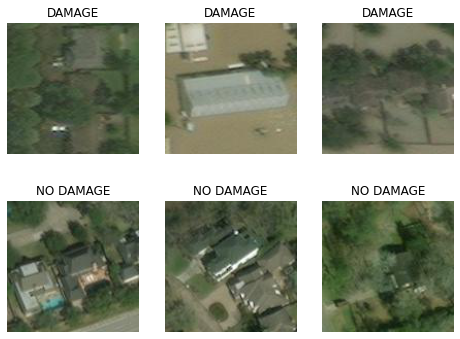

In [272]:
# training set folder
train_dir = os.path.join(DIR, 'train_another')

# get the list of jpegs from sub image class folders
damage_imgs = [fn for fn in os.listdir(f'{train_dir}/damage') if fn.endswith('.jpeg')]
no_damage_imgs = [fn for fn in os.listdir(f'{train_dir}/no_damage') if fn.endswith('.jpeg')]

# randomly select 3 of each
select_damage = np.random.choice(damage_imgs, 3, replace = False)
select_no_damage = np.random.choice(no_damage_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/damage/{select_damage[i]}'
        label = 'DAMAGE'
    else:
        fp = f'{train_dir}/no_damage/{select_no_damage[i-3]}'
        label = 'NO DAMAGE'
    ax = fig.add_subplot(2, 3, i+1)
    
    fn = image.load_img(fp, target_size = (128,128), color_mode='rgb')
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

## Trends Across Images

In this section I load all training images as numpy arrays in order to calculate summary statics on them.

### Load Images into Numpy Arrays

In [32]:
# making n X m matrix
def img2np(path, list_of_filename, size = (128, 128)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'rgb')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    
    return full_mat


In [285]:
# training set folder
val_dir = os.path.join(DIR, 'validation_another')
val_damage_imgs = [fn for fn in os.listdir(f'{val_dir}/damage') if fn.endswith('.jpeg')]

In [286]:
test_array = img2np(f'{val_dir}/damage/', val_damage_imgs)

In [289]:
test_array[0]

array([64., 63., 62., ..., 75., 75., 72.], dtype=float32)

In [33]:
# run it on our folders
damage_arrays = img2np(f'{train_dir}/damage/', damage_imgs)
no_damage_arrays = img2np(f'{train_dir}/no_damage/', no_damage_imgs)

### Average Image by Class

Here I find the average value for each pixel and then generate an "average image" for each class in order to compare.

For both damage and no damage images we see that a structure tends to be located within the center of the image.

For damage images, the pixel values around the structure tend to be lower in value than around the no damage images. Perhaps this is because damage images tend to have flood waters around the structures, which are a different color than unflooded ground.

In [282]:
def find_mean_img(full_mat, title, size = (128, 128)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=85, vmax=110, cmap='plasma')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.colorbar()
    plt.show()
    return mean_img

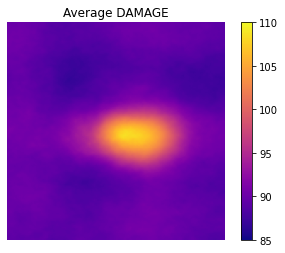

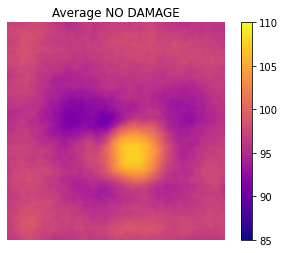

In [283]:
damage_mean = find_mean_img(damage_arrays, 'DAMAGE')
no_damage_mean = find_mean_img(no_damage_arrays, 'NO DAMAGE')

### Standard Deviation by Class

The function below is similar to above but instead of calculating the mean pixel value it plots the the standard deviation for each pixel for each class.

Standard deviation around the edges of the image appears to be (slightly) greater for the no damage images. Perhaps this is because debris around the structures creates more variation between images in that class.

In [298]:
def find_std_img(full_mat, title, size = (128, 128)):
    # calculate the average
    var_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    var_img = var_img.reshape(size)
    plt.imshow(var_img, vmin=20, vmax=70, cmap='plasma')
    plt.title(f'Standard Deviation {title}')
    plt.colorbar()
    plt.axis('off')
    plt.show()
    return var_img

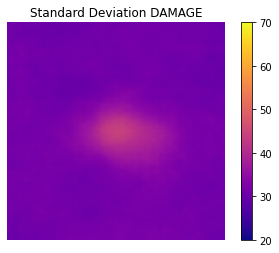

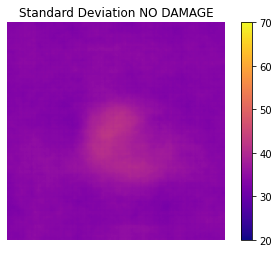

In [299]:
damage_std = find_std_img(damage_arrays, 'DAMAGE')
no_damage_std = find_std_img(no_damage_arrays, 'NO DAMAGE')

### Contrast between average images

Here I plotted the difference between the mean images for the two classes (damage and no damage). Dark blue and dark red are where there is the greatest difference and white is where there is the least.

The white pixels appear to form the outline of a structure - this is expected since all images of both classes have a structure in the center of the image. The difference values are higher in the center (roof?) and edges (area surrounding the structure).

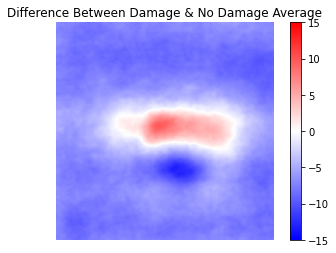

In [304]:
contrast_mean = damage_mean - no_damage_mean
plt.imshow(contrast_mean, vmin=-15, vmax=15, cmap='bwr')
plt.title(f'Difference Between Damage & No Damage Average')
plt.colorbar()
plt.axis('off')
plt.show()

### Eigenimages

The functions below leverage PCA to produce eigenimages for the two image classes. The eigenimages are not easily recognizable to the human eye, unlike eignimages based on faces or other images with more regular repeating features. There are hints of basic geometric shapes with right angles, as would be expected from images of structures.

It is telling, however, that when the function is told to produce eigenimages that produce 70% of the variation in each class, the damage class only requires 19 principle components while the no damage class requires 56. This is consistent with our earlier finding that the standard deviation for pixel values across the no damage class tended to be higher than the damage class.

In [76]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (128, 128)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (128, 128)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

Number of PC:  19


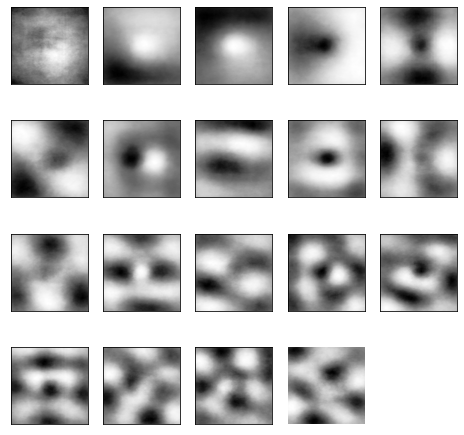

Number of PC:  56


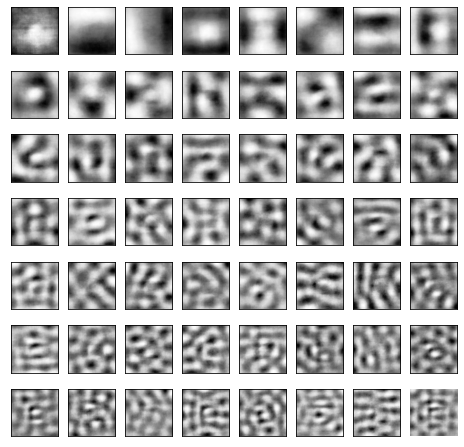

In [77]:
plot_pca(eigenimages(damage_arrays, 'DAMAGE'))
plot_pca(eigenimages(no_damage_arrays, 'NO DAMAGE'))

## Geographic Distribution

Finally, I wanted to sense check the geographic distribution of the training data by class. This is possible because the GPS coordinates are contained in the filename for each image file. Here I create a dataframe with damage class and latitude/longitude coordinates by parsing the filenames. Then I convert this into a GeoDataFrame and plot against a basemap.

We can see that the training data appears to come from 3 distinct areas. In one area, all structures in the training dataset are damaged, while in the other two there is a mix. Within those two there are clear spatial patterns of where flooding/damage occured and where it didn't.

In [185]:
#convert list of filenames into table of lat/long coordinates

#damage set
damage_df = pd.DataFrame(damage_imgs, columns=['Filename'])
damage_df = damage_df.Filename.str.split('_', expand=True)
damage_df = damage_df.rename(columns={0: 'lon', 1: 'lat'})
damage_df.lat = damage_df.lat.str.rstrip('.jpeg')
damage_df['damage'] = 1

#no_damage set
no_damage_df = pd.DataFrame(no_damage_imgs, columns=['Filename'])
no_damage_df = no_damage_df.Filename.str.split('_', expand=True)
no_damage_df = no_damage_df.rename(columns={0: 'lon', 1: 'lat'})
no_damage_df.lat = no_damage_df.lat.str.rstrip('.jpeg')
no_damage_df['damage'] = 0

#concatenate
all_df = pd.concat([damage_df, no_damage_df])

In [146]:
#convert to geodataframe and convert to Web Mercator
all_gdf = gpd.GeoDataFrame(all_df, geometry=gpd.points_from_xy(all_df.lon, all_df.lat))
all_gdf = all_gdf.set_crs(epsg=4326)
all_gdf = all_gdf.to_crs(epsg=3857)

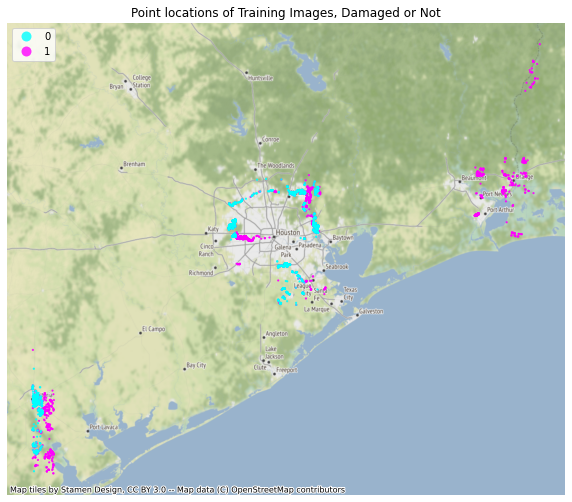

In [193]:
#plot by damage class w/ basemap
ax = all_gdf.plot(column='damage',categorical=True, figsize=(10, 10), alpha=0.8, s=1.5, legend=True, cmap='cool')
cx.add_basemap(ax)
plt.title(f'Point locations of Training Images, Damaged or Not')
plt.axis('off')
plt.show()

By plotting histograms of the distribution of longitudes we can see the trends displayed in the map confirmed. The damage class has three distinct groupings, while the no damage class has only two. This is because the northeastern group does not have any no damage cases.

In [207]:
#convert lat/long columns from text to float
all_gdf.lon = all_gdf.lon.astype('float')
all_gdf.lat = all_gdf.lat.astype('float')

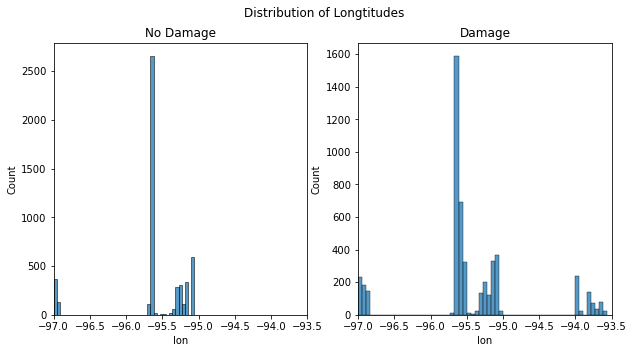

In [265]:
#plot distribution of longitude values
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.histplot(all_gdf[all_gdf.damage==0].lon, ax=ax1)
fig.suptitle('Distribution of Longtitudes')
ax1.set_xlim([-97, -93.5])
ax1.set_title('No Damage')

sns.histplot(all_gdf[all_gdf.damage==1].lon, ax=ax2)
ax2.set_xlim([-97, -93.5])
ax2.set_title('Damage');

Taking a closer look at the southwestern grouping we can see what appears to be two dinstinct subgroupings of damaged ande undamaged structures.

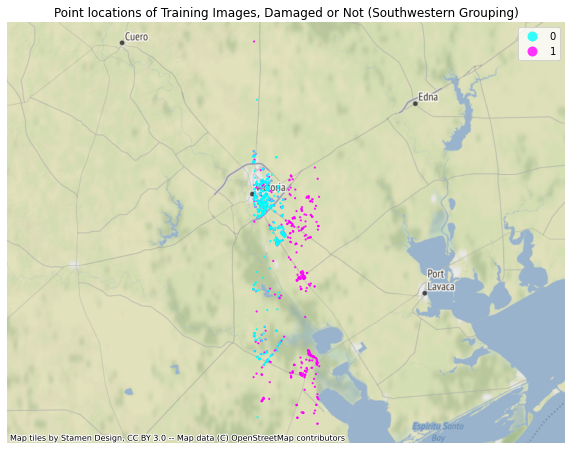

In [258]:
#plot by damage class w/ basemap - zoomed in on southwest grouping
southern_gdf = all_gdf[all_gdf.lon < -96]
axx = southern_gdf.plot(column='damage',categorical=True, figsize=(10, 10), alpha=0.8, s=1.5, legend=True, cmap='cool')
axx.set_xlim([-10798210.908-60000, -10782077.708+60000])
cx.add_basemap(axx)
plt.title(f'Point locations of Training Images, Damaged or Not (Southwestern Grouping)')
plt.axis('off')
plt.show()